# <center>Hazardous Freight Prediction: Siamese Neural Network and NLP</center>
<center>By Nigel Story</center>

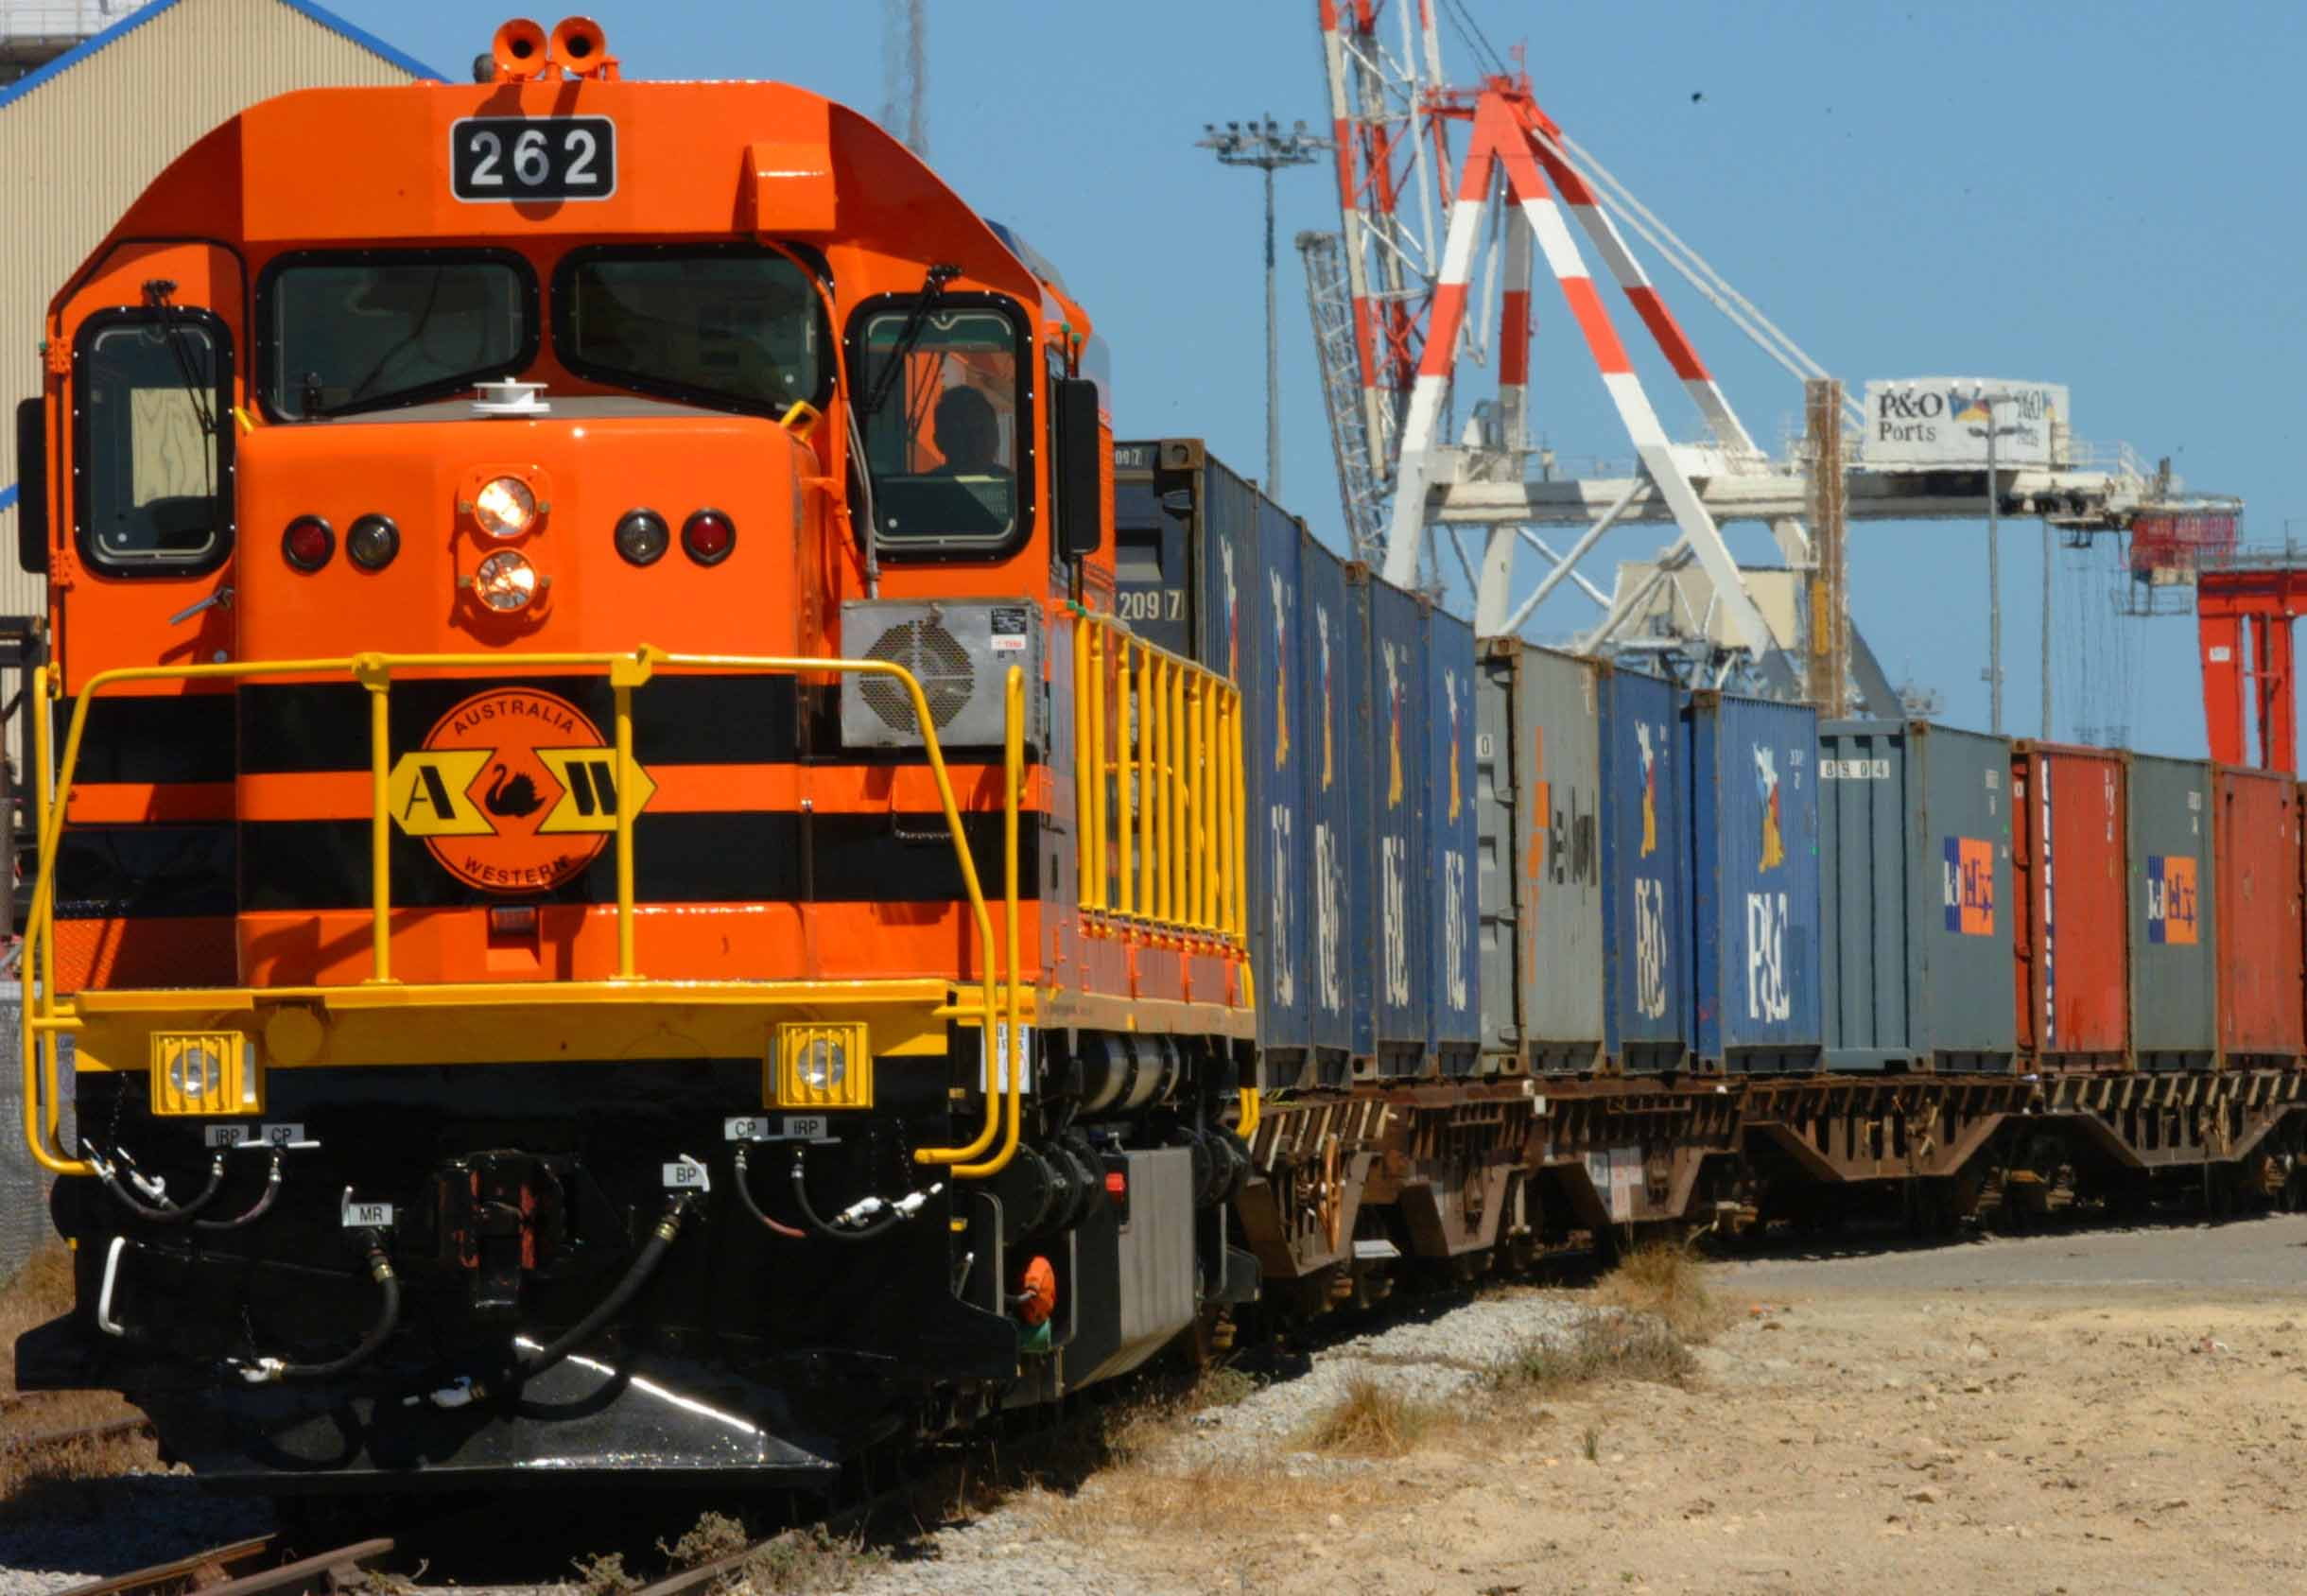

## Contents

* [Introduction](#introduction)
* [ETL and Data Cleaning](#etl)
* [EDA and Feature Selection](#eda)
* [Feature Engineering](#fe)
* [Model Definition](#md)
* [Model Evaluation](#me)
* [Conclusion](#conclusion)

---

## Introduction <a class='anchor' id='introduction'></a>



Throughout the COVID-19 pandemic we've heard a lot about the "essential worker": the doctors and nurses on the front lines, the cashiers and clerks keeping our grocery stores open, the postal workers delivering vital parcels across the U.S., and countless others who risk their health and safety every day to keep the rest of us on our feet. Freight line workers are certainly among this heroic group, with their work being invaluable in supplying the country with vital goods. It's dangerous work, regardless of the pandemic, involving operating heavy machinery and moving massive cargo freights, and with this project we seek to make the job a little safer using machine learning.

The objective of this project is to find the probability that a freight car with unknown contents contains hazardous materials, hazardous waste, or chemicals provided the rest of the information on the car's waybill. The ability to predict this would help freight line workers to anticipate potential hazards and take appropriate measures to stay safe.

We'll be using a mixed approach here, modeling-wise, using a simple multi-layer perceptron neural network to make predictions from the rail car's properties (i.e. its estimated short-line miles, number of articulated units, ownership category, and the intermodal code), and then we'll use the car's route data (origin, destination, and interchange states) to build a model analogous to sentiment analysis using NLP techniques.

### About the Data

This project uses the Carload Sample Waybill (waybill) data. This data contains a stratified sample of all U.S. rail traffic for rail companies that terminate 4,500 or more revenue carloads annually. The waybill data is confidential for a number of reasons and can only be access by entities operating within approved industries, but the Surface Transportation Board makes a publicly available version of the data for independent use. 

The publicly available waybill data, along with the reference guide documentation, can be downloaded from the Surface Transportation Board site <a href="https://prod.stb.gov/reports-data/waybill/">here</a>.

### Package Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import plaidml.keras as pk
pk.install_backend()
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv1D, Dropout, LeakyReLU, MaxPooling1D, Embedding, Flatten, Input, Concatenate
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

---

## ETL and Data Cleaning <a class='anchor' id='etl'></a>

The data file has been formatted as a flat, 247-byte-per-line .txt file. Let's take a look at the raw data to get an idea of what we're working with.

In [2]:
FILE_PATH = './'

In [3]:
with open(FILE_PATH + 'PublicUseWaybillSample2019.txt', 'r') as f:
    lines = f.readlines()
    print(lines[:5])

['01101701190001PC214XPI 41   0000   374220000027000002700000075800000000000000000020990030070140401704000641                  0641100000000000000000000000000000  0000879                                              T00004000000108000000030320000000\n', '12141701190001PS342FCA 46X  0001PC 461110000010000001000000193100000000000000000019999900860120400004000101                  0641100000662217628806100507050504EF8841379                                              T00004000000040000000077240000040\n', '01121801190001RF483FBC 49   0000   374220000030000003000000165200000000000000000020990000360130401704001465                  1810100000225060708007091015060208E41507900                                              T00004000000120000000066080000000\n', '01261801190001RA806XP  38   0000   371490000043000004300000496100000000000000000019190921080140400004000961                  1344110000151112509210091117001610E41500000                                              T000040000001720000001984

At face-value, this data is a nightmare; it just looks like maybe 6 columns of perhaps tab-delimited alpha-numeric serial references. However, we can find some help in the reference guide in the section "2019 Surface Transportation Board Public Use Waybill 247-Byte Record Layout" (p. 99). Here we find a table that will help us in decoding the data, shown below:

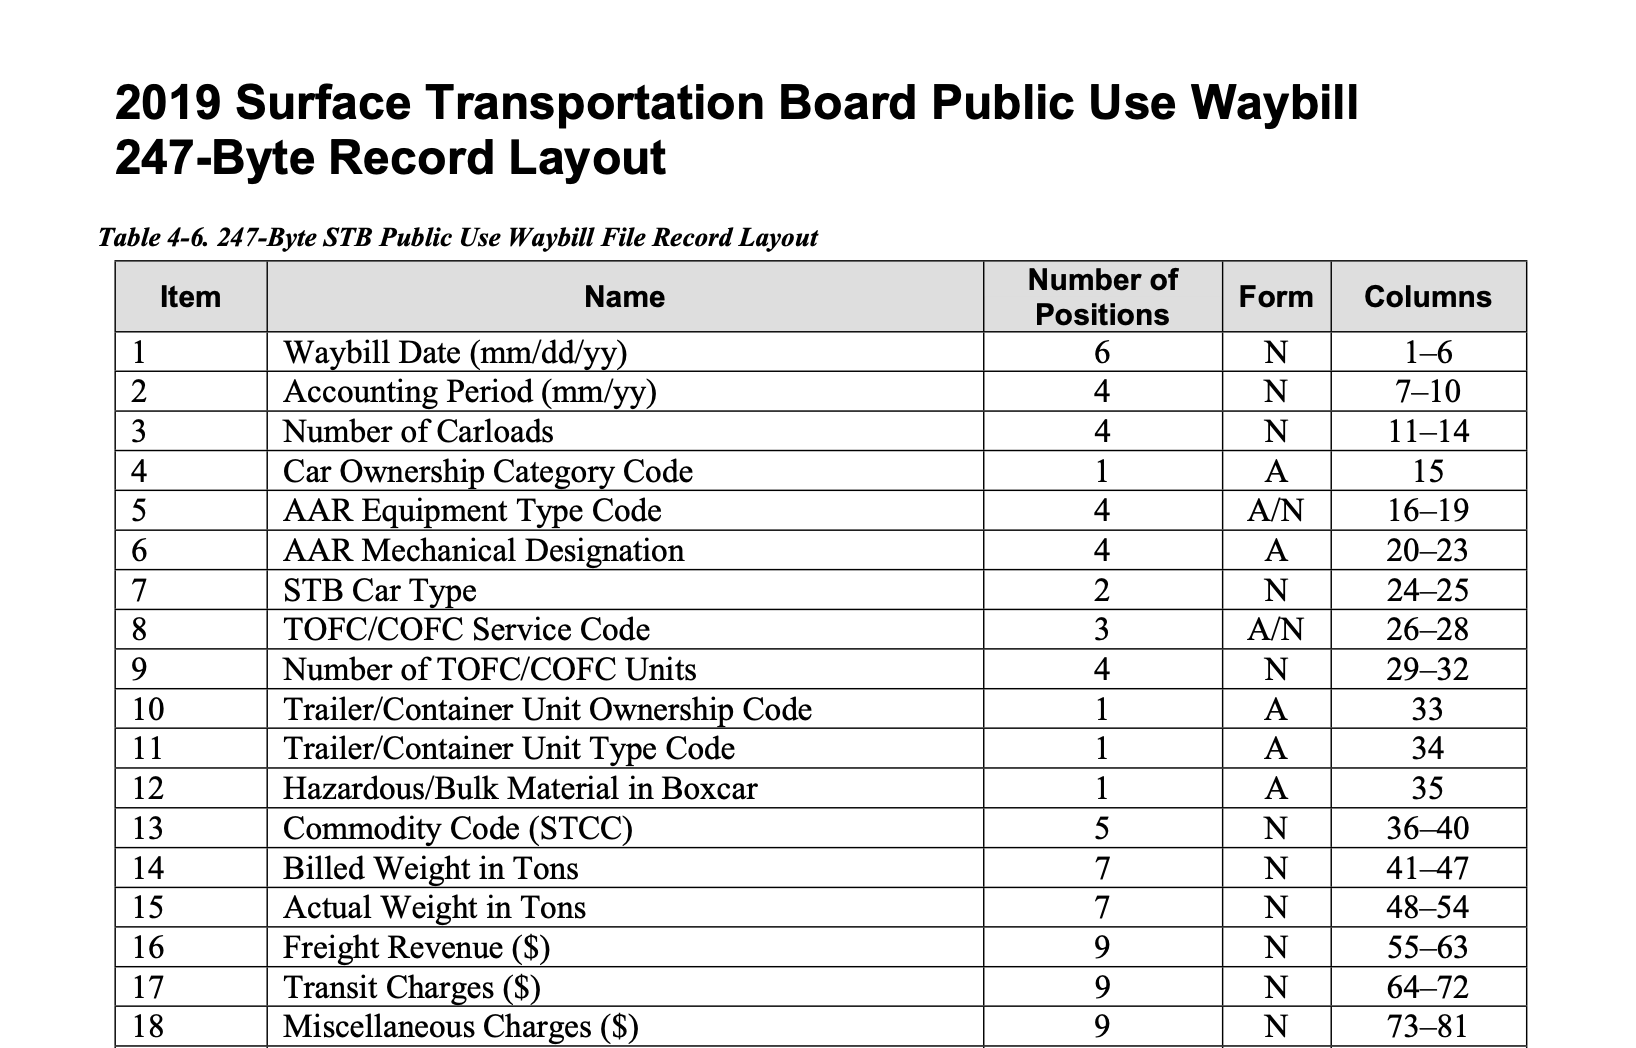

This is only the first few rows of the table, but this table provides us with the field names in the data, along with the character positions that hold the data for a particular field.

First, since this table is in a pdf document, we'll need to get it into some workable format for us to use in our code. I was able to copy and paste it into Excel, but the formatting was still a hassle. After formatting the data, I saved it to a .csv file, to be read in by pandas.

Let's take a look at the data:

In [4]:
column_lookup_path = FILE_PATH + 'column_positions_lookup.csv'

In [5]:
column_lookup_df = pd.read_csv(column_lookup_path, delimiter=',')
column_lookup_df.head()

,item,name,number_of_positions
0,1,waybill_date,6
1,2,accounting_period,4
2,3,number_of_carloads,4
3,4,car_ownership_category_code,1
4,5,aar_equipment_type_code,4


Now let's make a lookup dictionary that we can use to look up a column's name and the number of character positions that column should contain.

In [6]:
column_lookup_dict = {k: v for k,v in column_lookup_df[['name', 'number_of_positions']].to_numpy()}

We can use this dictionary, along with the following function, to parse each line of the data and create a JSON-like list of dictionaries containing the data.

In [7]:
def read_waybill_line(line, lookup_dict):
    out = {}
    start = 0
    for key in lookup_dict:
        if key == 'blank':
            continue
        end = start + int(lookup_dict[key])
        out[key] = line[start: end]
        start = end
        
    return out

In [8]:
dataset = [read_waybill_line(line, column_lookup_dict) for line in lines]

Let's convert the data to a pandas DataFrame and preview it.

In [9]:
df = pd.DataFrame(dataset)
df.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes,routing_error_flag,expanded_carloads,expanded_tons,expanded_freight_revenue
0,011017,0119,0001,P,C214,XPI,41,,0000,,...,0000,,,00,0,0879,,,,
1,121417,0119,0001,P,S342,FCA,46,X,0001,P,...,0504,E,F,88,4,1379,,,,
2,011218,0119,0001,R,F483,FBC,49,,0000,,...,0208,E,4,15,0,7900,,,,
3,012618,0119,0001,R,A806,XP,38,,0000,,...,1610,E,4,15,0,0000,,,,
4,020218,0119,0015,P,C112,LO,41,,0000,,...,0903,E,4,66,0,5600,,,,


That looks much better!

Now that we have the data in a readable format, let's take a look at the shape, data types, and memory footprint.

In [10]:
df.shape

(676257, 61)

In [11]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676257 entries, 0 to 676256
Data columns (total 61 columns):
waybill_date                             676257 non-null object
accounting_period                        676257 non-null object
number_of_carloads                       676257 non-null object
car_ownership_category_code              676257 non-null object
aar_equipment_type_code                  676257 non-null object
aar_mechanical_designation               676257 non-null object
stb_car_type                             676257 non-null object
tofc_cofc_service_code                   676257 non-null object
number_of_tofc_cofc_units                676257 non-null object
trailer_container_unit_ownership_code    676257 non-null object
trailer_container_unit_type_code         676257 non-null object
hazardous_bulk_material_in_boxcar        676257 non-null object
commodity_code_stcc                      676257 non-null object
billed_weight_in_tons                    676257 non-null 

So this is a pretty big dataset, with over 670k rows, and it's eating up a ton of memory -- about 2.4 GB!

We have a couple of red flags here, though, that we should inspect: first, 670k rows is big, but not big enough to merit a 2.3 GB memory footprint; second, none of the columns contain any null values -- which we know should not be the case from our preview of the pandas data.

So we'll tackle the "no nulls" issue first. From inspecting the original .txt file, we can see that all the values that should be null have been filled with spaces, which eats up memory by both simply having the spaces there at all and by forcing some of the numerical columns to be encoded as text. However, with some regex, we can find and replace these values with np.nan.

Once that is done, we can cast the columns to their proper data types, and check their min and max values to make sure that we are using the proper number of bits for our integers.

The following function will complete these tasks and give us a summary at the end of the memory reduction.

In [12]:
def minimize_mem_usage(df, verbose=False):
    start_mem_usg = df.memory_usage(deep=True).sum() / 1024**2 # MB
    
    # replace space-filled values with np.nan
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    df['waybill_date'] = pd.to_datetime(df['waybill_date'], format='%m%d%y')
    df['accounting_period'] = pd.to_datetime(df['accounting_period'], format='%m%y')
    
    # cast numerical columns to int
    for col in df.columns:
        if col in ['waybill_date', 'accounting_period']:
            continue
        try:
            df[col] = df[col].astype(int)
        except ValueError:
            continue
    
    # drop na's
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)
    
    NAlist = []
    for col in df.columns:
        if df[col].dtype not in ['object', 'datetime64[ns]']:
            
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
    
    # Print final result
    end_mem_usg = df.memory_usage().sum() / 1024**2
    mem_reduction = 100*end_mem_usg/start_mem_usg
    
    if verbose:
        print("___MEMORY REDUCTION STATS:___")
        print("Starting memory usage was {:.2f}MB".format(start_mem_usg))
        print("Current memory usage is {:.2f}MB".format(end_mem_usg))
        print("This is {:.2f}% of the initial size".format(mem_reduction))
    
    return df

In [13]:
df = minimize_mem_usage(df, verbose=True)

___MEMORY REDUCTION STATS:___
Starting memory usage was 2462.56MB
Current memory usage is 127.05MB
This is 5.16% of the initial size


We have great performance coming out of our memory optimization, with a reduction of about 95% of the original memory!

Let's have a quick look at our datatypes to make sure everything went well and makes sense.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676257 entries, 0 to 676256
Data columns (total 53 columns):
waybill_date                             676257 non-null datetime64[ns]
accounting_period                        676257 non-null datetime64[ns]
number_of_carloads                       676257 non-null uint8
car_ownership_category_code              676257 non-null object
aar_equipment_type_code                  676257 non-null object
aar_mechanical_designation               676257 non-null object
stb_car_type                             676257 non-null uint8
tofc_cofc_service_code                   410310 non-null object
number_of_tofc_cofc_units                676257 non-null uint8
trailer_container_unit_ownership_code    410367 non-null object
trailer_container_unit_type_code         410367 non-null object
hazardous_bulk_material_in_boxcar        61465 non-null object
commodity_code_stcc                      676257 non-null uint16
billed_weight_in_tons                    6762

We can see above that we now have plenty of null values (which is a good sign), and our integer data types have been optimized to the lowest bit size of unsigned integer types, giving us a very reasonable 127MB of data.

We'll have one final look at the data, and then save it to a .csv for later use in analysis.

In [15]:
df.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,tare_weight_of_car,outside_length,outside_width,outside_height,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes
0,2017-01-10,2019-01-01,1,P,C214,XPI,41,NaN,0,NaN,...,0,0,0,0,0,NaN,NaN,0,0,879
1,2017-12-14,2019-01-01,1,P,S342,FCA,46,X,1,P,...,2176,28806,1005,705,504,E,F,88,4,1379
2,2018-01-12,2019-01-01,1,R,F483,FBC,49,NaN,0,NaN,...,607,8007,910,1506,208,E,4,15,0,7900
3,2018-01-26,2019-01-01,1,R,A806,XP,38,NaN,0,NaN,...,1125,9210,911,1700,1610,E,4,15,0,0
4,2018-02-02,2019-01-01,15,P,C112,LO,41,NaN,0,NaN,...,526,4200,1008,1506,903,E,4,66,0,5600


In [16]:
df.to_csv('./prelim_waybill_data.csv', index=False)

### Combining with other data sources

We have our waybill data clean now, but we will need a couple of other datasets to get a complete picture. In particular, we will need to decode the Surface Transportation Commodity Codes (STCC) and Business Economic Area (BEA) codes, so that we can know what type of freight is being moved and its origin and destination points.

The STCC code headers and BEA codes can be found in similar tables to the data position tables in the reference guide. I've copied the tables into csv's.

We'll read all the data back into Spark DataFrames, so that we can take advantage of Spark SQL to combine the data.

In [17]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()

In [18]:
waybill = spark.read.csv('./prelim_waybill_data.csv', header=True, inferSchema=True)
stcc = spark.read.csv('./stcc_data.csv', header=True, inferSchema=True)
bea = spark.read.csv('./bea_codes.csv', header=True, inferSchema=True)

waybill.createOrReplaceTempView('waybill')
stcc.createOrReplaceTempView('stcc')
bea.createOrReplaceTempView('bea')

#### Read in hazardous data

In [19]:
haz_query = """
SELECT
    w.*,
    s.short_description as stcc_description,
    o.location as origin_location,
    t.location as terminal_location,
    s.is_hazardous
FROM waybill w
JOIN stcc s ON s.stcc_code = LEFT(w.commodity_code_stcc,2) /* stcc_code contains only the first 2 digits of the stcc */
JOIN bea o ON o.bea_code = w.origin_bea_area
JOIN bea t ON t.bea_code = w.termination_bea_area
WHERE 1=1
    AND s.is_hazardous = 1
"""

hazardous = spark.sql(haz_query)
hazardous.count()

34243

In [20]:
hdf = hazardous.toPandas()
hdf.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes,stcc_description,origin_location,terminal_location,is_hazardous
0,2018-04-16,2019-01-01,1,P,T105,T,50,None,0,None,...,306,E,4,77,0,0,Chemicals,"Chicago-Gary-Kenosha, IL-IN-WI","Los Angeles-Riverside-Orange County, CA-AZ",1
1,2018-08-30,2019-01-01,1,P,C214,LO,41,None,0,None,...,806,E,4,88,0,0,Chemicals,"Chicago-Gary-Kenosha, IL-IN-WI","Philadelphia-Wilmington-Atlantic City, PA-NJ-D...",1
2,2018-09-05,2019-01-01,1,P,C214,LO,41,None,0,None,...,810,E,4,88,0,0,Chemicals,"New Orleans, LA-MS","Birmingham, AL",1
3,2018-10-10,2019-01-01,1,P,S342,FCA,46,X,1,P,...,504,E,F,88,4,1300,Chemicals,"Baton Rouge, LA-MS",Alberta,1
4,2018-10-23,2019-01-01,1,P,T106,T,51,None,0,None,...,400,E,4,77,0,0,Chemicals,"Chicago-Gary-Kenosha, IL-IN-WI","Shreveport-Bossier City, LA-AR",1


#### Read in non-hazardous data

In [21]:
nonhaz_query = """
SELECT
    w.*,
    s.short_description as stcc_description,
    o.location as origin_location,
    t.location as terminal_location,
    s.is_hazardous
FROM waybill w
JOIN stcc s ON s.stcc_code = LEFT(w.commodity_code_stcc,2)
JOIN bea o ON o.bea_code = w.origin_bea_area
JOIN bea t ON t.bea_code = w.termination_bea_area
WHERE 1=1
    AND s.is_hazardous = 0
"""

There are far more non-hazardous shipments than hazardous ones, so we'll take a random sample from the non-hazardous data equal in size to the hazardous dataset.

In [22]:
nonhaz = spark.sql(nonhaz_query).rdd.takeSample(False, len(hdf), 42)
nonhaz = sc.parallelize(nonhaz)
schema = hazardous.schema
nhdf = nonhaz.toDF(schema=schema).toPandas()

nhdf.head()

,waybill_date,accounting_period,number_of_carloads,car_ownership_category_code,aar_equipment_type_code,aar_mechanical_designation,stb_car_type,tofc_cofc_service_code,number_of_tofc_cofc_units,trailer_container_unit_ownership_code,...,extreme_outside_height,type_of_wheel_bearings_and_brakes,number_of_axles,draft_gear,number_of_articulated_units,aar_error_codes,stcc_description,origin_location,terminal_location,is_hazardous
0,2019-04-24,2019-04-01,1,P,T389,T,51,None,0,None,...,306,E,4,77,0,0,Petroleum Products,"Houston-Galveston-Brazoria, TX","Houston-Galveston-Brazoria, TX",0
1,2019-03-08,2019-03-01,1,R,V418,FA,47,None,0,None,...,504,E,4,10,0,0,Transportation Equipment,"Portland-Salem, OR-WA","Kansas City, MO-KS",0
2,2019-04-28,2019-04-01,1,R,S635,FCA,46,M,1,P,...,808,E,8,66,3,1367,Mixed Shipments,"Los Angeles-Riverside-Orange County, CA-AZ","Atlanta, GA-AL-NC",0
3,2019-09-03,2019-09-01,1,T,V978,FA,47,None,0,None,...,508,E,4,10,0,0,Transportation Equipment,"Detroit-Ann Arbor-Flint, MI","St. Louis, MO-IL",0
4,2019-06-19,2019-06-01,1,P,S342,FCA,46,X,1,P,...,504,E,F,88,4,1367,Unidentified Waste,"Seattle-Tacoma-Bremerton, WA","Pendleton, OR-WA",0


As our objective is to predict whether or not a shipment is hazardous, we won't need all of the columns. I've selected a handful of columns that would appear, based on their data descriptions in the reference guide, to have a relationship with whether or not the freight contains hazardous materials.

In [23]:
df = pd.concat([hdf, nhdf], axis=0)

relevant_cols = [
    'is_hazardous',
    'car_ownership_category_code',
    'miscellaneous_charges_dollars',
    'all_rail_intermodal_code',
    'estimated_short_line_miles',
    'number_of_interchanges',
    'number_of_articulated_units',
    'origin_location', 
    'interchange_state_1', 
    'interchange_state_2',                
    'interchange_state_3', 
    'interchange_state_4', 
    'interchange_state_5', 
    'terminal_location'
]

df = df[relevant_cols]
df.head()

len(df)

68486

This is now our prepared dataset, and I'll write it to a csv to be read in for EDA.

In [24]:
df.to_csv('./prepared_waybill_data.csv', index=False)

---

## EDA and Feature Selection <a class='anchor' id='eda'></a>

Let's start by taking a look at the correlation matrix, to see if any of our numerical columns correlate with the is_hazardous column.

In [25]:
df.corr()

,is_hazardous,miscellaneous_charges_dollars,all_rail_intermodal_code,estimated_short_line_miles,number_of_interchanges,number_of_articulated_units
is_hazardous,1.000000,-0.008042,-0.175271,-0.354814,0.008080,-0.570608
miscellaneous_charges_dollars,-0.008042,1.000000,0.010225,0.009447,-0.015822,-0.004391
all_rail_intermodal_code,-0.175271,0.010225,1.000000,0.147743,0.119982,0.141289
estimated_short_line_miles,-0.354814,0.009447,0.147743,1.000000,0.208191,0.504362
number_of_interchanges,0.008080,-0.015822,0.119982,0.208191,1.000000,-0.089477
number_of_articulated_units,-0.570608,-0.004391,0.141289,0.504362,-0.089477,1.000000


There are slight negative correlations with the number of articulated units and the estimated short-line miles. The `all_rail_intermodal_code` should not actually be a numerical value, as the codes (1, 2, and 9) simply refer to whether or not the freight has been moved using multiple travel media (i.e. it traveled by ship for a time, then moved to the railway). We'll examine these values categorically in a future step.

As we discover columns that have weak predictive power, we will append them to a list of columns to drop, then we will drop them from our data at the end of our analysis.

In [26]:
drop_cols = []

Next, we'll take a look at the distribution of each data point. While some columns don't correlate with hazard, if their distributions differ widely between hazardous and non-hazardous freight, then we might still be able to get some segmenting power from them.

In [27]:
grouped = df.groupby('is_hazardous')

In [28]:
grouped.mean()

,miscellaneous_charges_dollars,all_rail_intermodal_code,estimated_short_line_miles,number_of_interchanges,number_of_articulated_units
is_hazardous,,,,,
0,11.42581,5.901936,1314.652630,0.157142,2.641416
1,7.93879,4.502497,761.128114,0.164063,0.400958


In [29]:
grouped.std()

,miscellaneous_charges_dollars,all_rail_intermodal_code,estimated_short_line_miles,number_of_interchanges,number_of_articulated_units
is_hazardous,,,,,
0,226.332045,3.892399,819.678226,0.420387,1.937867
1,206.821272,3.968175,625.963166,0.436034,1.201439


At a glance, we can see a few things: miscellaneous charges tend to be higher and more variant for non-hazardous shipments; estimated short-line miles are far less for hazardous freight (meaning hazardous freight travels a smaller distance, on average); and non-hazardous freight tend to travel in articulated units more frequently than hazardous freight.

Let's visualize these with kernel density plots.

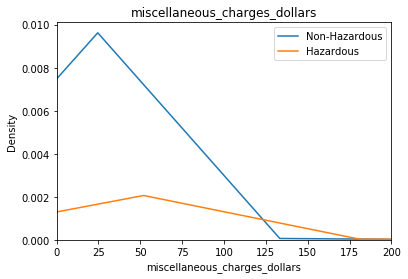

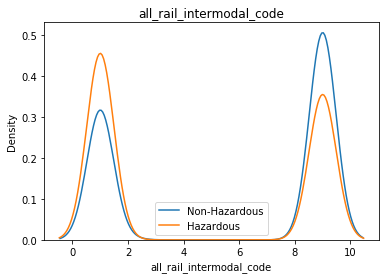

__HAZARDOUS__
9    20960
1    13106
2      177
Name: all_rail_intermodal_code, dtype: int64
__NON-HAZARDOUS__
1    19223
9    14988
2       32
Name: all_rail_intermodal_code, dtype: int64




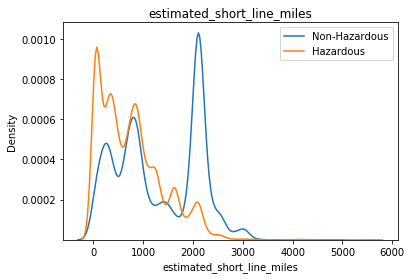

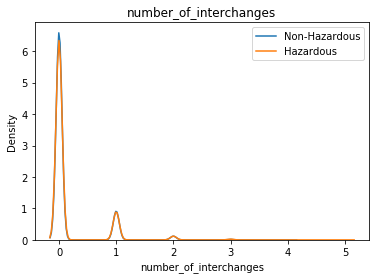

__HAZARDOUS__
0    29541
1     4099
2      530
3       70
4        3
Name: number_of_interchanges, dtype: int64
__NON-HAZARDOUS__
0    29407
1     4173
2      549
3      110
4        3
5        1
Name: number_of_interchanges, dtype: int64




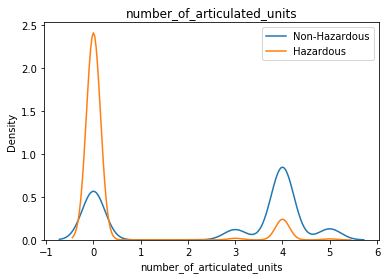

__HAZARDOUS__
4    17436
0    11660
5     2647
3     2471
2       29
Name: number_of_articulated_units, dtype: int64
__NON-HAZARDOUS__
0    30785
4     3065
3      234
5      150
2        9
Name: number_of_articulated_units, dtype: int64




In [30]:
for c in df.columns[df.dtypes!='object']:
    if c == 'is_hazardous':
        continue
    
    sns.kdeplot(df.loc[df['is_hazardous']==0, c], label='Non-Hazardous')
    sns.kdeplot(df.loc[df['is_hazardous']==1, c], label='Hazardous')
    if c == 'miscellaneous_charges_dollars':
        plt.xlim(0, 200)
    plt.title(c)
    plt.legend()
    plt.show()
    
    if c in ['all_rail_intermodal_code', 'number_of_interchanges', 'number_of_articulated_units']:
        print('__HAZARDOUS__')
        print(df.loc[df['is_hazardous']==0, c].value_counts())
        print('__NON-HAZARDOUS__')
        print(df.loc[df['is_hazardous']==1, c].value_counts())
    
    print('='*20)
    print('\n')

It seems that even though miscellaneous_charges_dollars tend to be higher, on average, for non-hazardous freight, we don't have many non-zero charges, so the data for this column will not be particularly useful. We'll add it to the drop list.

We can see some separability in the all rail/intermodal code. It seems that non-hazardous freight tend to have a higher likelihood of being unidentified (code 9), so we'll keep this column for now.

As we gathered from the correlation matrix, we can see that the estimated short-line miles are shorter for hazardous freight. This could be good for our future model.

The number of interchanges seems to be the same for both types of freight, so we will drop this column.

Hazardous shipments are less likely to travel in articulated units, as we saw in the correlation matrix, so we will keep this column.

In [31]:
drop_cols.append('miscellaneous_charges_dollars')

In [32]:
drop_cols.append('number_of_interchanges')

Let's take a look at our categorical columns now.

/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


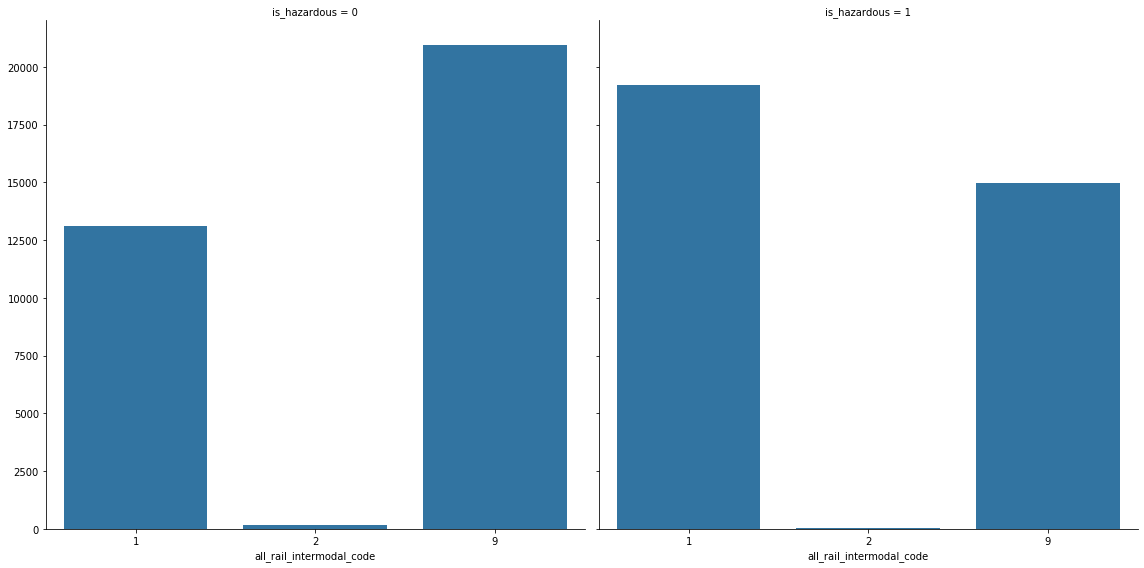

In [33]:
g = sns.FacetGrid(df, col='is_hazardous', height=8)
g.map(sns.countplot, 'all_rail_intermodal_code')

We see some evidence of separability in our all-rail/intermodal codes, so we will officially retain this column.

/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


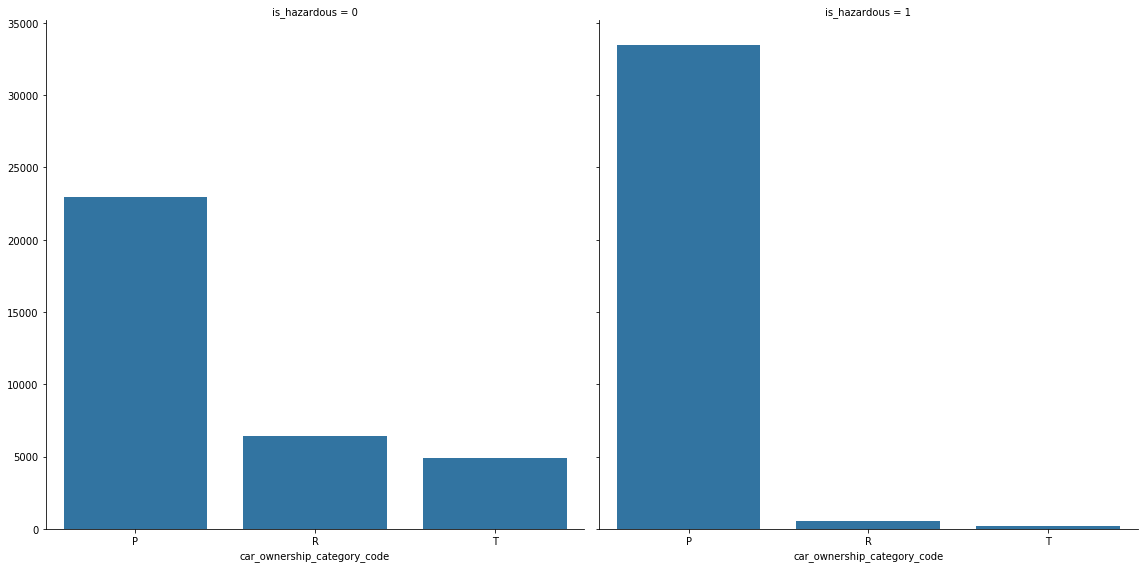

In [34]:
g = sns.FacetGrid(df, col='is_hazardous', height=8)
g.map(sns.countplot, 'car_ownership_category_code')

We see here that hazardous freight is more likely to be privately owned, so we will retain this column as well.

The following plots are for the origin locations, terminal locations, and interchange states along the route. These appear to have a good amount of predictive power, as it seems that hazardous and non-hazardous freight tend to originate in separate areas, arrive in separate areas, and follow differing routes that hazardous freight.

In [35]:
def plot_bars(df, colname):
    haz_cnt = df.loc[df['is_hazardous']==1, colname].value_counts().reset_index(drop=False)
    haz_cnt['is_hazardous'] = 'yes'
    nhaz_cnt = df.loc[df['is_hazardous']==0, colname].value_counts().reset_index(drop=False)
    nhaz_cnt['is_hazardous'] = 'no'

    cnts = pd.concat([haz_cnt, nhaz_cnt], axis=0)
    cnts.head()

    g = sns.catplot(
        data=cnts, kind="bar",
        x="index", y=colname, hue="is_hazardous",
        ci="sd", palette="dark", alpha=.6, height=8, aspect=3
    )
    
    x_max = min(len(cnts), 50)
    
    plt.xlim((-1,x_max))
    plt.xticks(rotation=90)
    plt.show()

Below, one can see that the distributions of terminal locations and origin locations differ widely between hazardous and non-hazardous freight. This will be a powerful predictor.

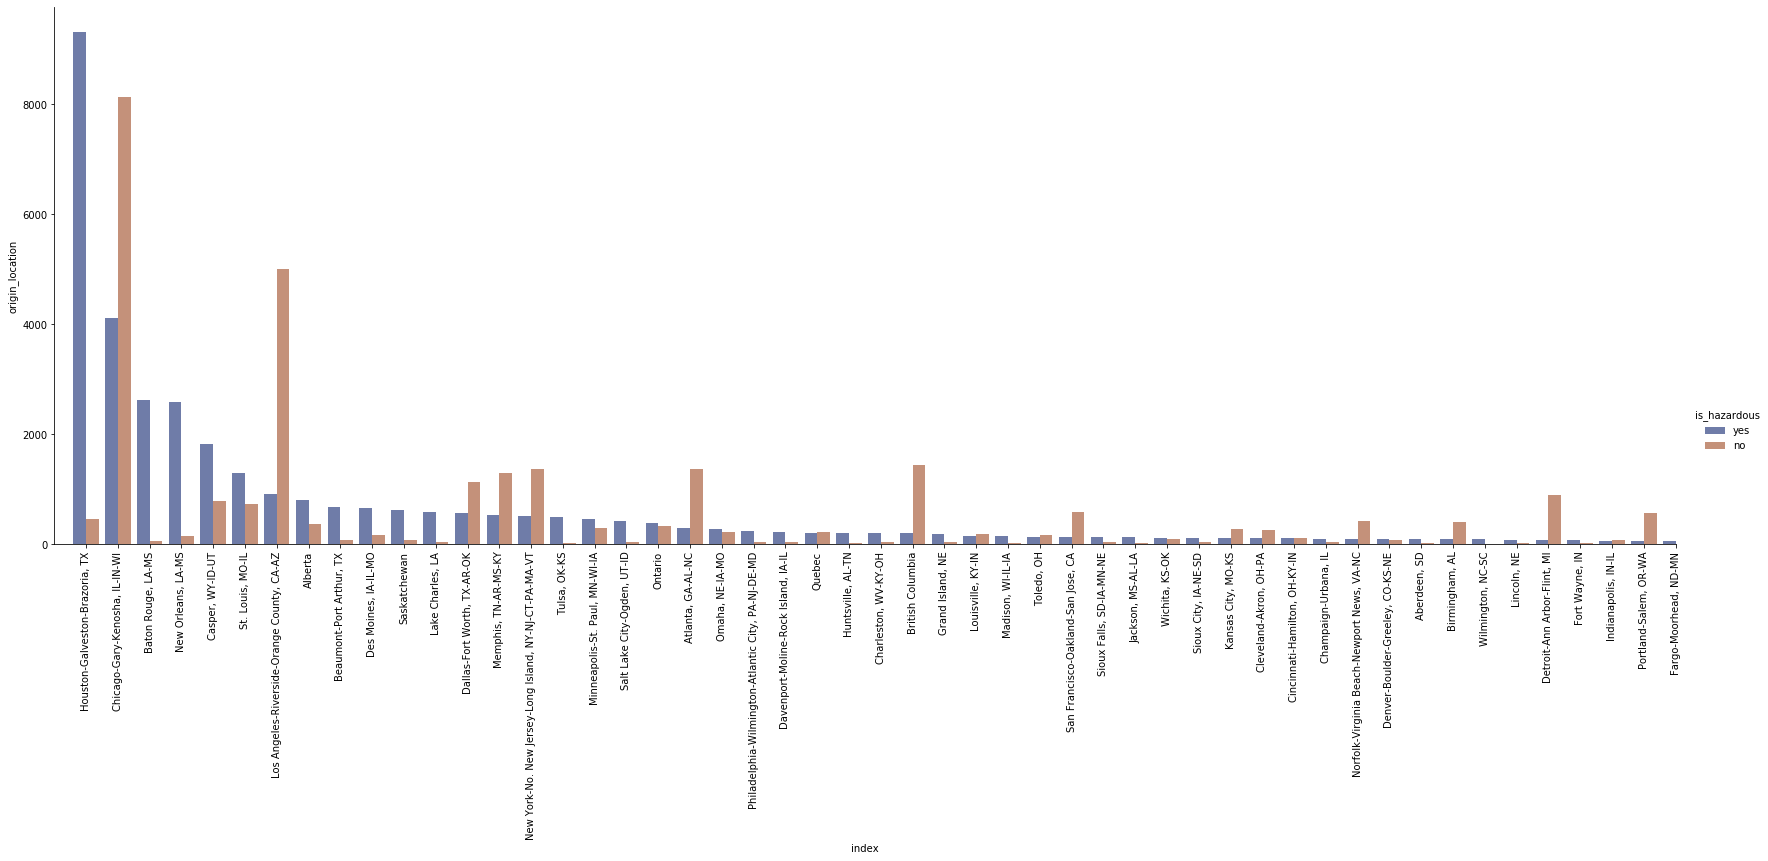

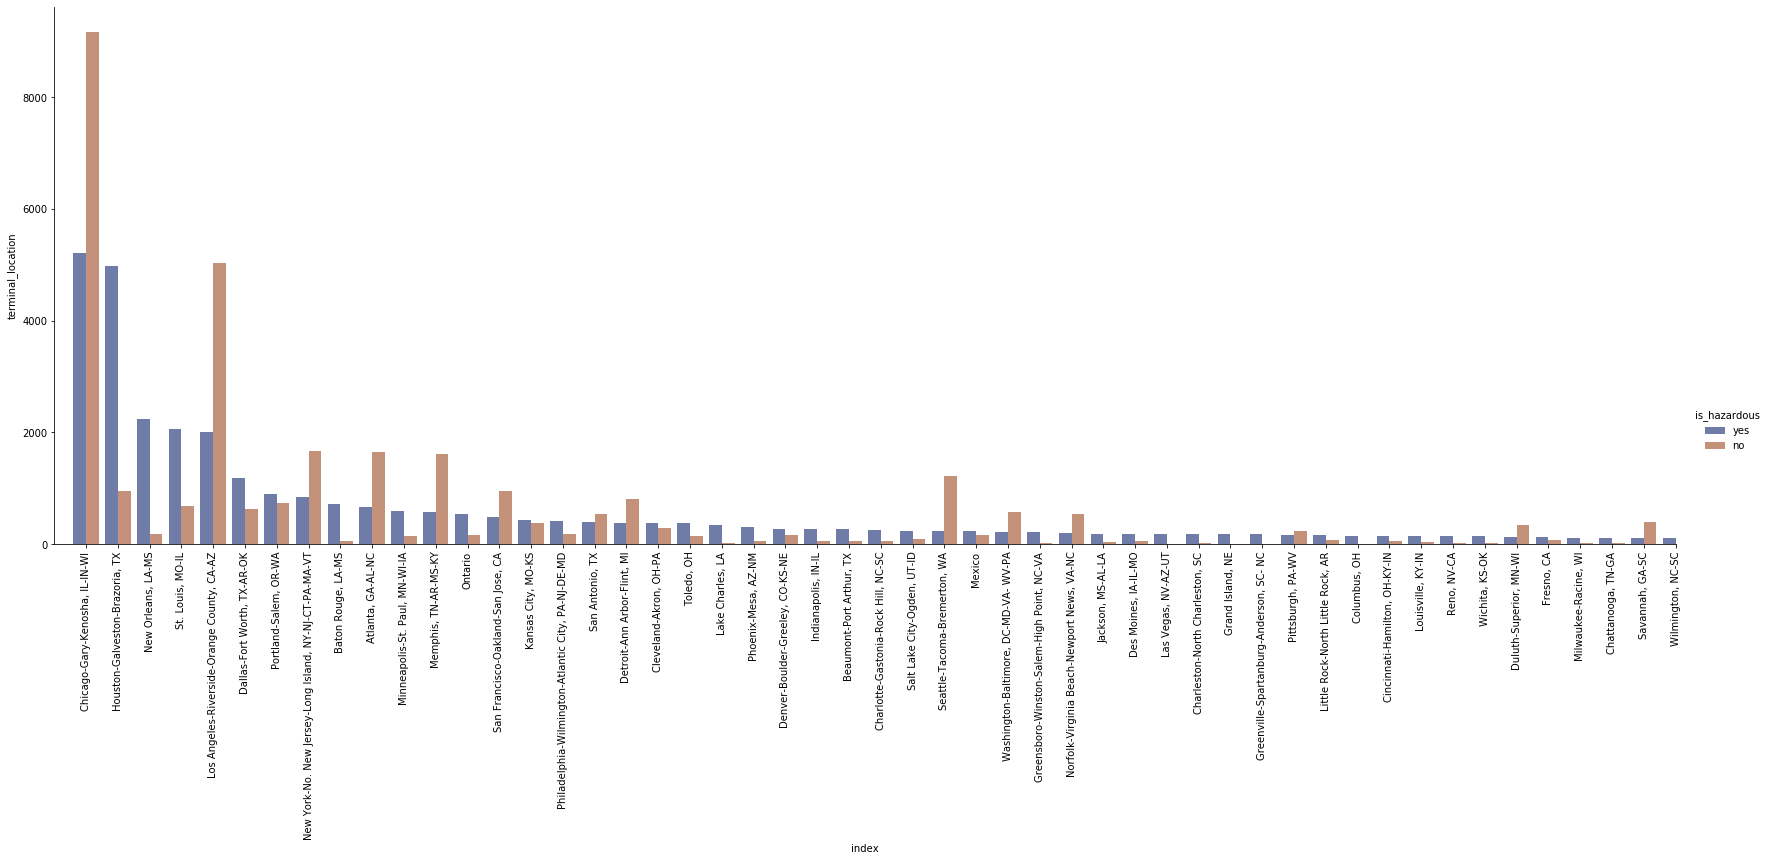

In [36]:
plot_bars(df, 'origin_location')
plot_bars(df, 'terminal_location')

The distributions for interchange states, while not as drastically different as those for origin and terminal location, will still be very informative for our model as well.

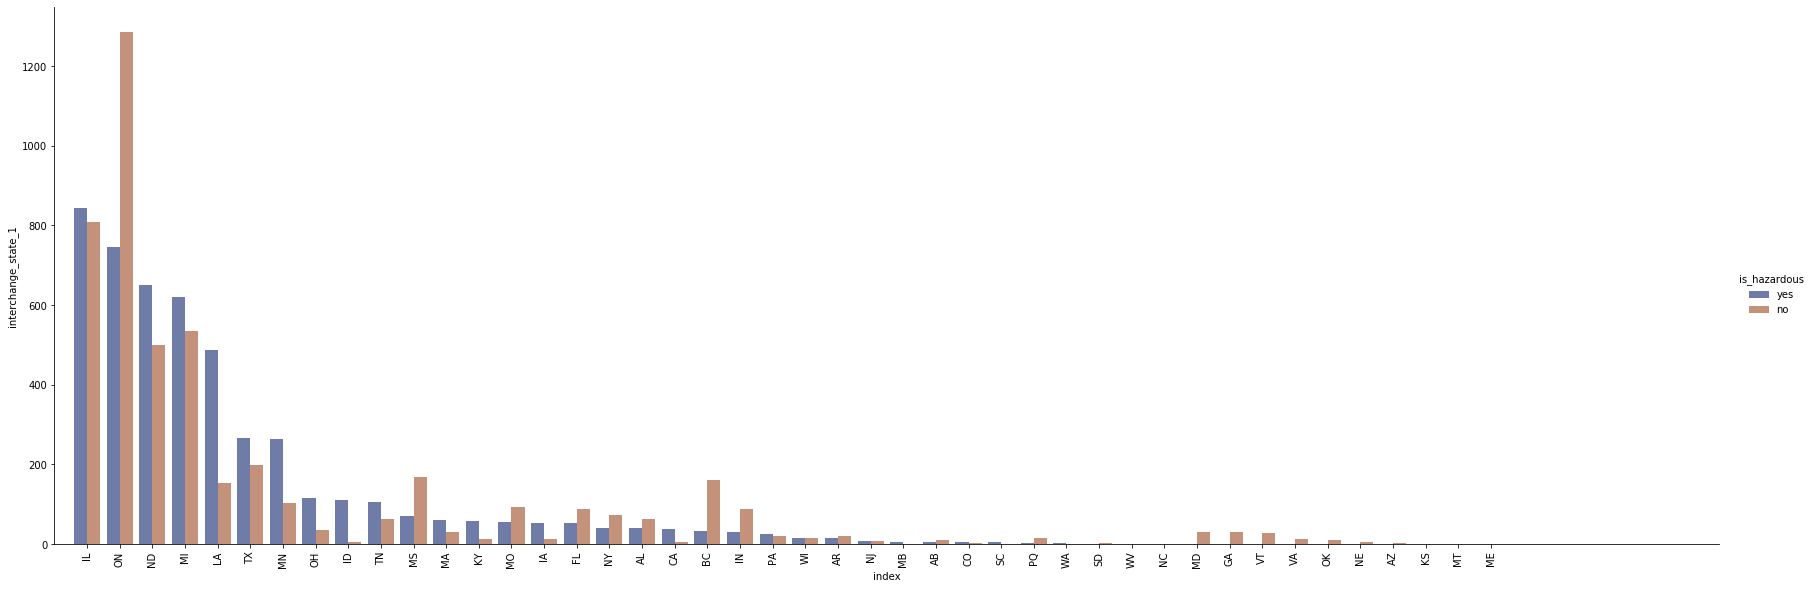

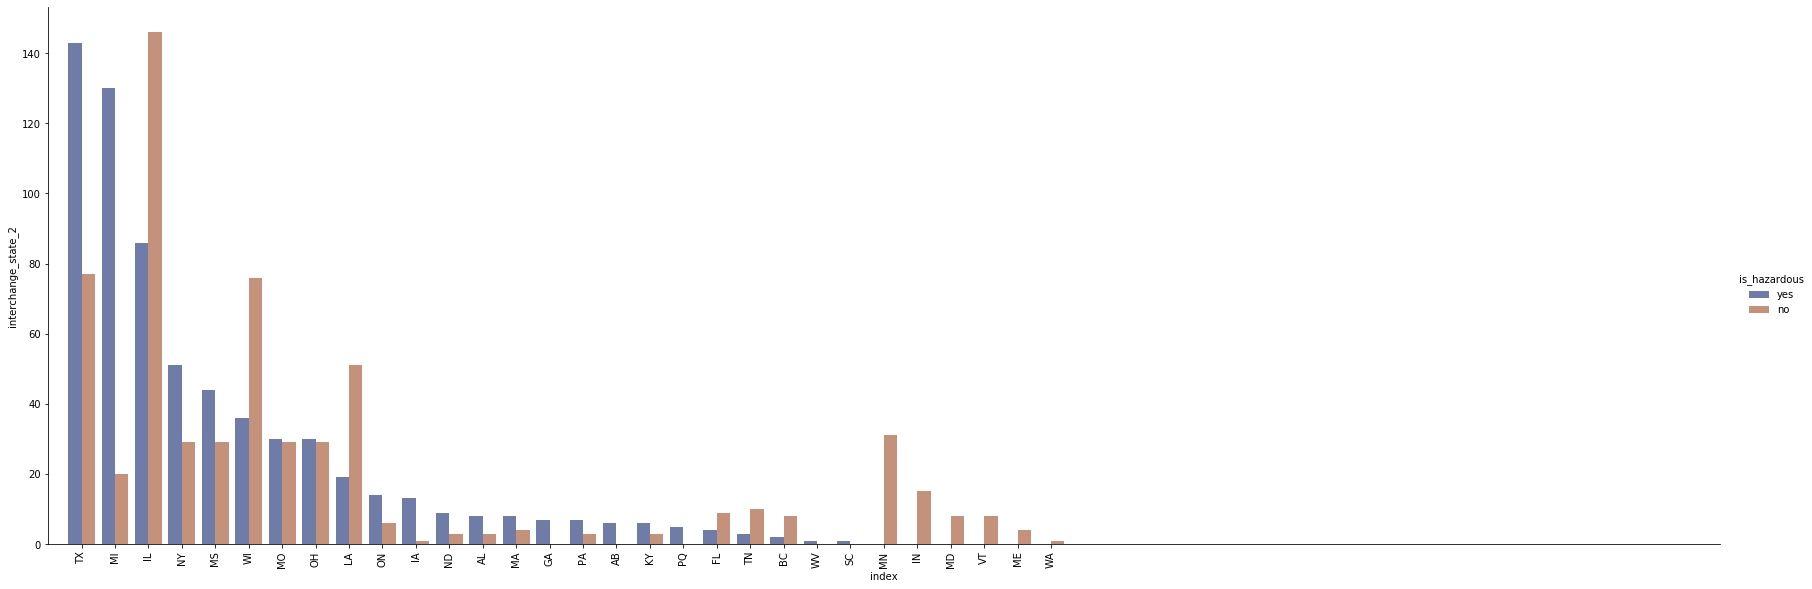

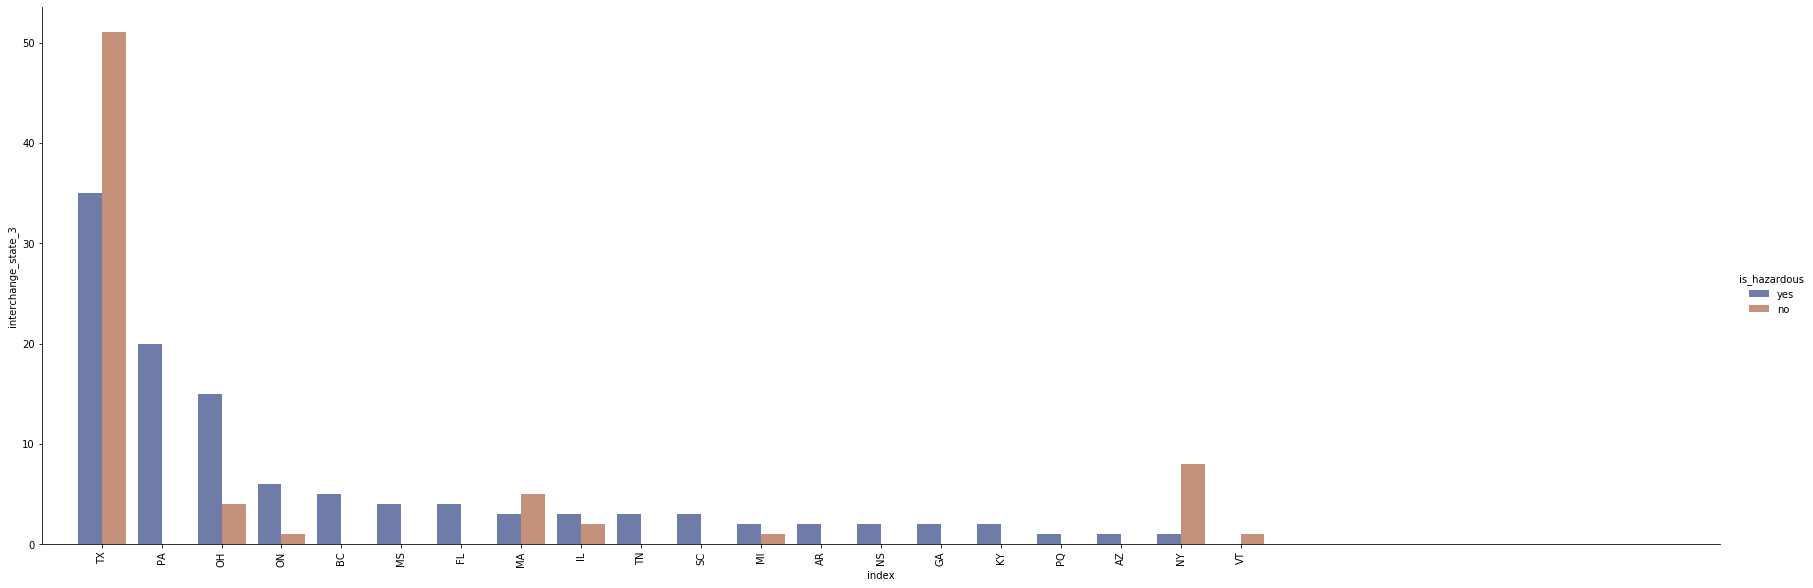

In [37]:
plot_bars(df, 'interchange_state_1')
plot_bars(df, 'interchange_state_2')
plot_bars(df, 'interchange_state_3')

Very few shipments have more than 3 interchanges, so we will drop interchange states 4 and 5.

In [38]:
drop_cols.append('interchange_state_4')
drop_cols.append('interchange_state_5')

Let's execute our column drops and save the final data to a csv.

In [39]:
df.drop(drop_cols, axis=1, inplace=True)

In [40]:
df.to_csv('./waybill_relevant_data.csv', index=False)

---

# Feature Engineering <a class='anchor' id='fe'></a>

During our EDA, we were able to do the feature selection, so now all that's left is to prepare the data with encoding and scaling. We'll also be developing the "route sentences," which will be the text representation of our train routes.

### For sequence data

We're going to try using some NLP techniques on the train route, since right now the routes are stored as sequences of string data. So let's engineer the features in the same ways we would engineer sentences, for example.

In this way our predictions become comparable to a simple case of sentiment analysis.

In [41]:
seq_cols = [
    'origin_location',
    'interchange_state_1',
    'interchange_state_2',
    'interchange_state_3',
    'terminal_location'
]


def to_sentence(row):
    ls = []
    for c in seq_cols:
        if (row[c] is None) or (row[c] is np.nan):
            continue
            
        ls.append(row[c].replace(', ', '').replace(' ', '').replace('-', ''))
        
    return ' '.join(ls)

    
routes = df.apply(to_sentence, axis=1).to_list()

In [42]:
routes[:10]

['ChicagoGaryKenoshaILINWI LosAngelesRiversideOrangeCountyCAAZ',
 'ChicagoGaryKenoshaILINWI PhiladelphiaWilmingtonAtlanticCityPANJDEMD',
 'NewOrleansLAMS AL BirminghamAL',
 'BatonRougeLAMS IL AB Alberta',
 'ChicagoGaryKenoshaILINWI ShreveportBossierCityLAAR',
 'CasperWYIDUT TX BeaumontPortArthurTX',
 'NewOrleansLAMS BeaumontPortArthurTX',
 'LosAngelesRiversideOrangeCountyCAAZ LosAngelesRiversideOrangeCountyCAAZ',
 'NewOrleansLAMS BeaumontPortArthurTX',
 'HoustonGalvestonBrazoriaTX TX TX Mexico']

Now that we have our "route sentences" we need to know the vocabulary size.

In [43]:
long_str = ' '.join(routes)

long_ls = long_str.split()
vocab_set = set()
for l in long_ls:
    vocab_set.add(l)
    
print(len(vocab_set))

212


We have 212 distinct words in our vocab, so we'll choose a vocab size of 300, allowing for some unseen values. The maximum route length is five stops, so our max sentence length will be 5 words.

In [44]:
vocab_size = 300
max_length = 5

Now we apply our encoding and padding, and then dump the numpy arrays of our prepared data and the encoder to a pickle file.

In [45]:
encoded_routes = [one_hot(r, vocab_size) for r in routes]
encoded_routes[:5]

[[187, 1], [187, 94], [224, 278, 1], [5, 36, 127, 106], [187, 247]]

In [46]:
with open('./one_hot_encoder.pickle', 'wb') as f:
    pickle.dump(one_hot, f)

In [47]:
padded_routes = pad_sequences(encoded_routes, maxlen=max_length, padding='post')
padded_routes[:5]

array([[187,   1,   0,   0,   0],
       [187,  94,   0,   0,   0],
       [224, 278,   1,   0,   0],
       [  5,  36, 127, 106,   0],
       [187, 247,   0,   0,   0]], dtype=int32)

In [48]:
X_seq = padded_routes
y = df['is_hazardous'].to_numpy()

In [49]:
seq_data = (X_seq, y)

with open('sequence_data.pickle', 'wb') as f:
    pickle.dump(seq_data, f)

### For numerical and category data

For our traditional numerical and category data, we'll be applying one-hot encoding and min-max scaling, respectively.

In [50]:
num_cols = [
    'estimated_short_line_miles',
    'number_of_articulated_units'
]

cat_cols = [
    'car_ownership_category_code', 
    'all_rail_intermodal_code'
]

In [51]:
nums = df[num_cols]
cats = df[cat_cols].astype(str)

In [52]:
df['all_rail_intermodal_code'] = df['all_rail_intermodal_code'].astype(str)
encoded_cats = pd.get_dummies(cats)
encoded_cats.head()

,car_ownership_category_code_P,car_ownership_category_code_R,car_ownership_category_code_T,all_rail_intermodal_code_1,all_rail_intermodal_code_2,all_rail_intermodal_code_9
0,1,0,0,1,0,0
1,1,0,0,0,0,1
2,1,0,0,1,0,0
3,1,0,0,0,0,1
4,1,0,0,1,0,0


In [53]:
X_cats = encoded_cats.to_numpy()

In [54]:
scaler = MinMaxScaler()
X_nums = scaler.fit_transform(nums)

X_nums[:10]

array([[0.38061041, 0.        ],
       [0.1454219 , 0.        ],
       [0.06283662, 0.        ],
       [0.44344704, 0.8       ],
       [0.15439856, 0.        ],
       [0.27648115, 0.        ],
       [0.04847397, 0.        ],
       [0.01256732, 0.        ],
       [0.04847397, 0.        ],
       [0.11849192, 0.        ]])

Now that the data is scaled and encoded, we will pickle the scaler and the numerical dataset.

In [55]:
with open('./min_max_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [56]:
X = np.concatenate([X_nums, X_cats], axis=1)
X.shape

(68486, 8)

In [57]:
X_seq.shape

(68486, 5)

In [58]:
num_data = (X, y)

with open('./numerical_data.pickle', 'wb') as f:
    pickle.dump(num_data, f)

Now we are ready to send our data to model training!

---

# Model Definition <a class='anchor' id='md'></a>

We're going to be training a Siamese Neural Network to make our predictions. This is not a very common approach, as it's typical that all the data going into a given neural network would be of the same type, but here we will need to feed the network numerical data as well as sequences of words, which require differing input layers and differing initial layer structures.

The structure of our Siamese Neural Network will be the following: the numerical data will be fed into a shallow multilayer perceptron model whose output will be weights from fully-connected layer with 64 nodes; the train route sequence data will be embedded into a vector field and then fed into a 1D Convolutional Neural Network, like one might use for sentiment analysis, outputting another fully-connected layer with 64 nodes. The weights from the two models' outputs will then be concatenated and fed into a third neural network -- a deep learning MLP --  which will give us our final predictions.

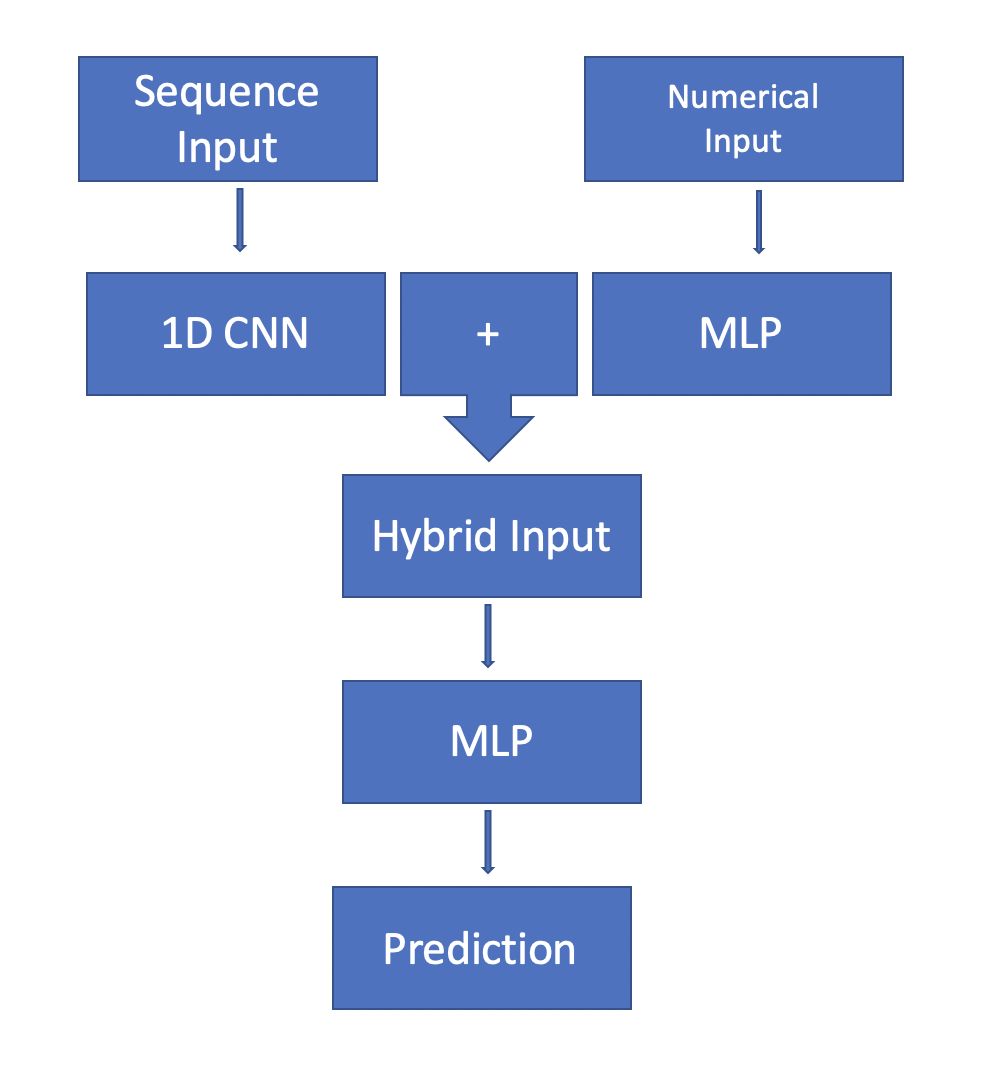

### Reading in training and validation data

In [59]:
with open('./sequence_data.pickle', 'rb') as f:
    sequence_data = pickle.load(f)
    
with open('./numerical_data.pickle', 'rb') as f:
    numeric_data = pickle.load(f)

In [60]:
X_seq, y = sequence_data

In [61]:
X_num, y = numeric_data

In [62]:
print(X_seq.shape)
print(X_num.shape)
print(y.shape)

(68486, 5)
(68486, 8)
(68486,)


In [63]:
X = np.concatenate([X_num, X_seq], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [64]:
xs_train, xs_test, ys_train, ys_test = train_test_split(X_seq, y, test_size=.33)
xn_train, xn_test, yn_train, yn_test = train_test_split(X_num, y, test_size=.33)

### Siamese Neural Network

In [65]:
vocab_size = 300
max_length = 5
batch_size = 32

In [66]:
def build_model():

    # cnn with only 1 dense layer
    seq_input = Input(shape=(max_length,))

    x = Embedding(vocab_size, 3, input_length=max_length)(seq_input)

    x = Conv1D(256, kernel_size=3, strides=1)(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)

    seq_output = Dense(64, activation='relu')(x)

    cnn = Model(inputs=seq_input, outputs=seq_output)

    # mlp with only one dense layer
    num_input = Input(shape=(8,))

    mlp_output = Dense(64, activation='relu')(num_input)

    mlp = Model(inputs=num_input, outputs=mlp_output)

    # combine
    combined = Concatenate()([cnn.output, mlp.output])
    
    z = Dense(512)(combined)
    z = LeakyReLU()(z)
    z = Dropout(.5)(z)
    
    z = Dense(512)(z)
    z = LeakyReLU()(z)
    z = Dropout(.2)(z)
    
    z = Dense(256)(z)
    z = LeakyReLU()(z)
    z = Dropout(.2)(z)
    
    z = Dense(64)(z)
    z = LeakyReLU()(z)
    z = Dropout(.2)(z)
    
    output = Dense(1, activation='sigmoid')(z)

    final_model = Model(inputs=mlp.inputs + cnn.inputs, outputs=[output])

    final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return final_model

In [67]:
model = build_model()

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


In [68]:
num_train = x_train[:, :8]
seq_train = x_train[:, 8:]

num_test = x_test[:, :8]
seq_test = x_test[:, 8:]

xc_train = [num_train, seq_train] 
xc_test = [num_test, seq_test] 

In [69]:
learning_rate_reduction_combined = ReduceLROnPlateau(monitor='val_acc', patience=3, 
                                            verbose=2, factor=0.5, min_lr=0.00001)

best_model_combined = ModelCheckpoint('./combined_cnn_mlp_model.3.h5', monitor='val_acc', verbose=2, 
                             save_best_only=True, mode='max')

early_stopping_combined = EarlyStopping(monitor='val_loss', min_delta=1e-10, 
                               patience=10, restore_best_weights=True)

In [70]:
hist = model.fit(xc_train, y_train,
         batch_size=batch_size,
         epochs=50,
         validation_data=(xc_test, y_test),
         callbacks = [learning_rate_reduction_combined, best_model_combined, early_stopping_combined],
         verbose=1
)

Train on 45885 samples, validate on 22601 samples
Epoch 1/50
45885/45885 [==============================] - 16s 342us/step - loss: 0.3317 - acc: 0.8795 - val_loss: 0.2978 - val_acc: 0.8911

Epoch 00001: val_acc improved from -inf to 0.89107, saving model to ./combined_cnn_mlp_model.3.h5
Epoch 2/50
45885/45885 [==============================] - 11s 247us/step - loss: 0.2974 - acc: 0.8936 - val_loss: 0.2864 - val_acc: 0.8936

Epoch 00002: val_acc improved from 0.89107 to 0.89363, saving model to ./combined_cnn_mlp_model.3.h5
Epoch 3/50
45885/45885 [==============================] - 11s 234us/step - loss: 0.2903 - acc: 0.8972 - val_loss: 0.2913 - val_acc: 0.8863

Epoch 00003: val_acc did not improve from 0.89363
Epoch 4/50
45885/45885 [==============================] - 11s 232us/step - loss: 0.2814 - acc: 0.9008 - val_loss: 0.2839 - val_acc: 0.8939

Epoch 00004: val_acc improved from 0.89363 to 0.89394, saving model to ./combined_cnn_mlp_model.3.h5
Epoch 5/50
45885/45885 [================


Epoch 00037: val_acc did not improve from 0.91629
Epoch 38/50
45885/45885 [==============================] - 11s 236us/step - loss: 0.2108 - acc: 0.9253 - val_loss: 0.2427 - val_acc: 0.9167

Epoch 00038: val_acc improved from 0.91629 to 0.91669, saving model to ./combined_cnn_mlp_model.3.h5
Epoch 39/50
45885/45885 [==============================] - 11s 232us/step - loss: 0.2111 - acc: 0.9252 - val_loss: 0.2437 - val_acc: 0.9161

Epoch 00039: val_acc did not improve from 0.91669
Epoch 40/50
45885/45885 [==============================] - 11s 234us/step - loss: 0.2111 - acc: 0.9252 - val_loss: 0.2409 - val_acc: 0.9171

Epoch 00040: val_acc improved from 0.91669 to 0.91708, saving model to ./combined_cnn_mlp_model.3.h5
Epoch 41/50
45885/45885 [==============================] - 11s 235us/step - loss: 0.2097 - acc: 0.9256 - val_loss: 0.2396 - val_acc: 0.9160

Epoch 00041: val_acc did not improve from 0.91708
Epoch 42/50
45885/45885 [==============================] - 11s 235us/step - loss: 0

This model appears to produce very good results, with an accuracy score of 91.8%.

In the following section, we'll evaluate its performance a bit deeper.

---

# Model Evaluation <a class='anchor' id='me'></a>

In [71]:
with open('./sequence_data.pickle', 'rb') as f:
    sequence_data = pickle.load(f)
    
with open('./numerical_data.pickle', 'rb') as f:
    numeric_data = pickle.load(f)
    
X_seq, y = sequence_data
X_num, y = numeric_data

X = np.concatenate([X_num, X_seq], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.33)

num_train = x_train[:, :8]
seq_train = x_train  

num_test = x_test[:, :8]
seq_test = x_test  

xc_train = [num_train, seq_train] 
xc_test = [num_test, seq_test] 

In [72]:
def false_neg(preds, y_test):
    fn = 0
    for i in range(len(preds)): 
        if preds[i]==0 and y_test[i]!=preds[i]:
            fn += 1

    return fn / len(y_test)

def evaluate(preds, y_test):
    print(f'Accuracy Score: {round(accuracy_score(preds, y_test)*100, 2)}%')
    print(f'AUC ROC Score: {round(roc_auc_score(preds, y_test)*100, 2)}%')
    print('\n__CLASSIFICATION REPORT__:')
    print(classification_report(preds, y_test))
    print('\n__CONFUSION MATRIX__:')
    print(confusion_matrix(preds, y_test)/len(y_test))
    print('\n__FALSE NEGATIVE RATE__:')
    print(f'{round(false_neg(preds, y_test)*100,2)}%')

In [73]:
cm = load_model('./combined_cnn_mlp_model.3.h5')

### Deep Learning Evaluation

In [74]:
input_data = [x_test[:, :8], x_test[:, 8:]]
cm_preds = cm.predict(input_data)
evaluate(np.rint(cm_preds), y_test)

Accuracy Score: 92.59%
AUC ROC Score: 92.6%

__CLASSIFICATION REPORT__:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93     11427
         1.0       0.92      0.93      0.93     11174

    accuracy                           0.93     22601
   macro avg       0.93      0.93      0.93     22601
weighted avg       0.93      0.93      0.93     22601


__CONFUSION MATRIX__:
[[0.46489093 0.04070616]
 [0.0334056  0.4609973 ]]

__FALSE NEGATIVE RATE__:
4.07%


For this evaluation, model performed at 92.5% accuracy, with precision and recall falling at similar values between 92% and 93%. Crucially, the false negative rate is very low here, at only ~4% -- which means our model will be able to keep railway workers safe about 96% of the time when a car with unknown contents arrives.

---

# Conclusion <a class='anchor' id='conclusion'></a>

Overall, I was very please with this model's performance -- with a validated accuracy score of 91.8% and a false negative rate of only 4%. Treating the rail car's routes as sentences and applying NLP methods, like vector embedding and sentiment analysis, worked better than I had expected, and has made me consider other applications where treating sequences in the same way as language might be beneficial.

### Thanks for reading!